In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pylab

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import logging
import gensim

import re
import unicodedata
import collections
import operator
import math
import time

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

import nltk
from nltk.collocations import *
from wordcloud import WordCloud



In [2]:
# load names, identify alphabet

infile = 'fundnames.txt'
data = open(infile, 'r').read()
chars = sorted(list(set(data)))

# add start/end chars
STARTCHAR ='{'
ENDCHAR = '}'
chars.append(STARTCHAR)
chars.append(ENDCHAR)
print(chars)
DATA_SIZE, VOCAB_SIZE = len(data), len(chars)
print('%d characters, %d unique.' % (DATA_SIZE, VOCAB_SIZE))

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

def mapstring(str):
    return list([char_to_ix[c] for c in str])


['\n', ' ', '!', '"', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '{', '}']
600287 characters, 59 unique.


In [3]:
# identify dictionary, count words
c = collections.Counter()

def fixstr(w):
    if w[-1] == ',':
        w = w[:-1]
    if w[-1] == '.':
        w = w[:-1]
    if w[-1] == ')':
        w = w[:-1]
    if w[0] == '(':
        w = w[1:]
    w = "".join(w.split('.'))
    return(w)

tokens = []

with open(infile) as ins:
    #unique
    uniquelines={}
    
    for line in ins:
        words2=[]
        words3=[]
        wordsline=[]
        for w in line.strip().split():
            words2.append(w)
            
        for w in words2:
            for w2 in w.split(','):
                words3.append(w2)
                
        for w in words3:
            if len(w) <= 1:
                continue
            w=fixstr(w)
            if len(w) <= 1:
                continue
            c.update([w])
            wordsline.append(w)
        uniquelines[" ".join(wordsline)]=1        

# redundant, count == c
vocabulary_size = len(c)

words = " " .join(uniquelines.keys()).strip().split()
count = []
count.extend(collections.Counter(words).most_common(vocabulary_size))
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
vocabulary_size = len(count)
print vocabulary_size


15015


In [4]:
# count most frequent words
# for this purpose get rid of punctuation
skipchars = ['\n', '!', '"', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',':', ';', '?', '@', '[', ']', '|', '{', '}']

# for this purpose skip these words

skipwords = ['llc',
 'inc',
 'ltd',
 'limited',
 'lp',
 'co',
 'company',
 'corporation',
 'corp',
 'private',
 'sa',
 'pte',
 'pty',
 'of',
 'ag',
 'the',
 'and',
 'gmbh',
 'de',
 'plc',
 'pvt',
 'bv',
 'sdn',
 'bhd',
            
]

words = " " .join(uniquelines.keys()).strip().split()

for w in words:
    skipfix = "".join([char for char in w if char not in skipchars])
    if len(skipfix) <= 1:
        continue
    if skipfix in skipwords:
        continue
    words2.append(skipfix)

display_count = collections.Counter(words2)
display_count.most_common(500)
   

[('management', 6659),
 ('capital', 6289),
 ('investment', 2757),
 ('asset', 2452),
 ('advisors', 1816),
 ('partners', 1043),
 ('wealth', 942),
 ('investments', 833),
 ('group', 809),
 ('holdings', 678),
 ('fund', 665),
 ('financial', 642),
 ('advisory', 514),
 ('services', 473),
 ('global', 341),
 ('international', 273),
 ('trust', 268),
 ('holding', 265),
 ('china', 228),
 ('associates', 185),
 ('funds', 185),
 ('trading', 181),
 ('hong', 177),
 ('kong', 175),
 ('asia', 157),
 ('research', 148),
 ('counsel', 145),
 ('markets', 140),
 ('investors', 137),
 ('consulting', 131),
 ('uk', 129),
 ('managers', 121),
 ('first', 120),
 ('shanghai', 118),
 ('street', 116),
 ('singapore', 114),
 ('advisers', 107),
 ('energy', 106),
 ('pension', 105),
 ('equity', 103),
 ('new', 103),
 ('credit', 103),
 ('canada', 98),
 ('pacific', 95),
 ('state', 92),
 ('life', 89),
 ('retirement', 88),
 ('hk', 88),
 ('real', 86),
 ('finance', 86),
 ('national', 83),
 ('hill', 82),
 ('point', 81),
 ('estate', 77)

In [5]:
# plot

most_common_labels = []
most_common_values = []

number_to_plot = 30

for label, value in list(display_count.most_common(number_to_plot)):
    most_common_labels.append(label)
    most_common_values.append(value)


data = [go.Bar(
            x=most_common_labels[:number_to_plot],
            y=most_common_values[:number_to_plot],
            marker = dict(color = list(range(number_to_plot)),
                          colorscale='Rainbow',
                          showscale=False),
    )]

layout = go.Layout(
    title = 'Most Popular Investment Advisor Words',
    xaxis=dict(
        showticklabels=True,
        tickangle=45,
        tickfont=dict(
            size=11,
            color='black'
        ),
    ),
    )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='most-popular')



In [6]:
# trigrams 
print("Most Frequent Trigrams\n")
#tokens = " ".join(uniquelines.keys()).split()
finder = TrigramCollocationFinder.from_words(words2)
finder.apply_freq_filter(10)
z = finder.ngram_fd.viewitems()
for gram, tricount in sorted(z, key=operator.itemgetter(1), reverse=True):
    print ("%s : %d " % (" ".join(gram), tricount))

# bigrams 
print("\nMost Frequent Bigrams\n")
finder = BigramCollocationFinder.from_words(words2)
finder.apply_freq_filter(50)
z = finder.ngram_fd.viewitems()
bigram_labels = []
bigram_values = []
for gram, bicount in sorted(z, key=operator.itemgetter(1), reverse=True):
    bigram_labels.append(" ".join(gram))
    bigram_values.append(bicount)
    print ("%s : %d " % (" ".join(gram), bicount))
    
words = " " .join(uniquelines.keys()).strip().split()



Most Frequent Trigrams

management hong kong : 67 
global asset management : 60 
asset management hong : 40 
asset management hk : 27 
asset management uk : 26 
asset management singapore : 23 
capital asset management : 20 
asset management japan : 19 
asset management capital : 19 
asset management asia : 18 
asset management international : 17 
real estate investment : 17 
hsbc global asset : 16 
international asset management : 16 
schroder investment management : 15 
capital hong kong : 15 
axa investment managers : 15 
deutsche asset management : 14 
manulife asset management : 14 
jpmorgan asset management : 14 
capital management capital : 14 
ubs global asset : 13 
asset management europe : 13 
blackrock asset management : 13 
capital management china : 13 
wealth management group : 13 
asset management us : 13 
state street global : 12 
asset management shanghai : 12 
asset management china : 12 
asset management first : 12 
investment management singapore : 11 
capital manag

In [7]:

# plot

most_common_labels = []
most_common_values = []

number_to_plot = 30

data = [go.Bar(
            x=bigram_labels[:number_to_plot],
            y=bigram_values[:number_to_plot],
            marker = dict(color = list(range(number_to_plot)),
                          colorscale='Rainbow',
                          showscale=False),
    )]

layout = go.Layout(
    title = 'Most Popular Investment Advisor Bigrams',    
    xaxis=dict(
        showticklabels=True,
        tickangle=45,
        tickfont=dict(
            size=11,
            color='black'
        ),
    ),
    margin=dict(b=100),    
    )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='most-popular-bigrams')


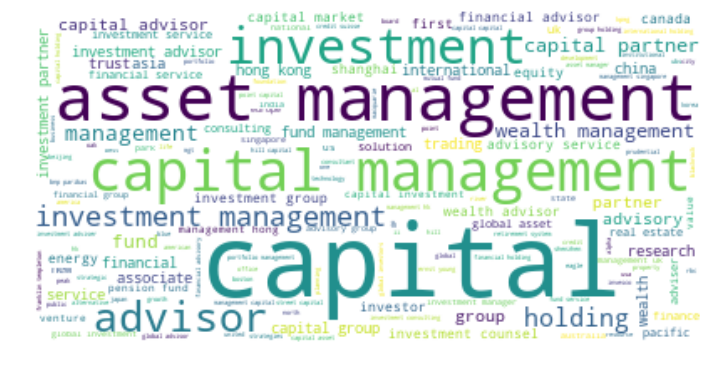

In [8]:
text = " ".join(words2)

font_path = "/home/ubuntu/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf"

wordcloud = WordCloud(background_color="white", max_font_size=60, max_words=2000).generate(text)
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# https://www.jasondavies.com/wordcloud/
# 500 words, 2 orientations -45 to 45, square root of n


In [9]:
# Look up Google News embeddings where they exist, create embedding matrix
# https://github.com/mmihaltz/word2vec-GoogleNews-vectors

print ("Loading Google News embedding model")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

try:
    model
except NameError:
    model = gensim.models.KeyedVectors.load_word2vec_format('~/Notebooks/GoogleNews-vectors-negative300.bin', binary=True)

# Create initializations
embedding_size = 300 # Dimension of the embedding vector.

print ("Mapping to Google News embedding where available")
# for each word in model, use its embeddings as initial val
arraylist = []
arraylabels = []
arraydict = {}
for i, (v,k) in enumerate(reverse_dictionary.items()):
    if (i % 1000) == 0:
        print ("Mapped %d words" % i)
    if k in model:
        initial_vals = np.float32(model[k])
        arraylist.append(initial_vals)
        arraydict[k]=len(arraylabels)
        arraylabels.append(k)

embeddings = np.array(arraylist)

print ("Mapped %d of %d words" % (embeddings.shape[0],vocabulary_size))


2018-02-19 07:31:32,444 : INFO : loading projection weights from ~/Notebooks/GoogleNews-vectors-negative300.bin


Loading Google News embedding model


2018-02-19 07:32:02,978 : INFO : loaded (3000000, 300) matrix from ~/Notebooks/GoogleNews-vectors-negative300.bin


Mapping to Google News embedding where available
Mapped 0 words
Mapped 1000 words
Mapped 2000 words
Mapped 3000 words
Mapped 4000 words
Mapped 5000 words
Mapped 6000 words
Mapped 7000 words
Mapped 8000 words
Mapped 9000 words
Mapped 10000 words
Mapped 11000 words
Mapped 12000 words
Mapped 13000 words
Mapped 14000 words
Mapped 15000 words
Mapped 6128 of 15015 words


In [10]:
# delete Google embeddings model which takes up excessive memory (5-6 GB)
del model

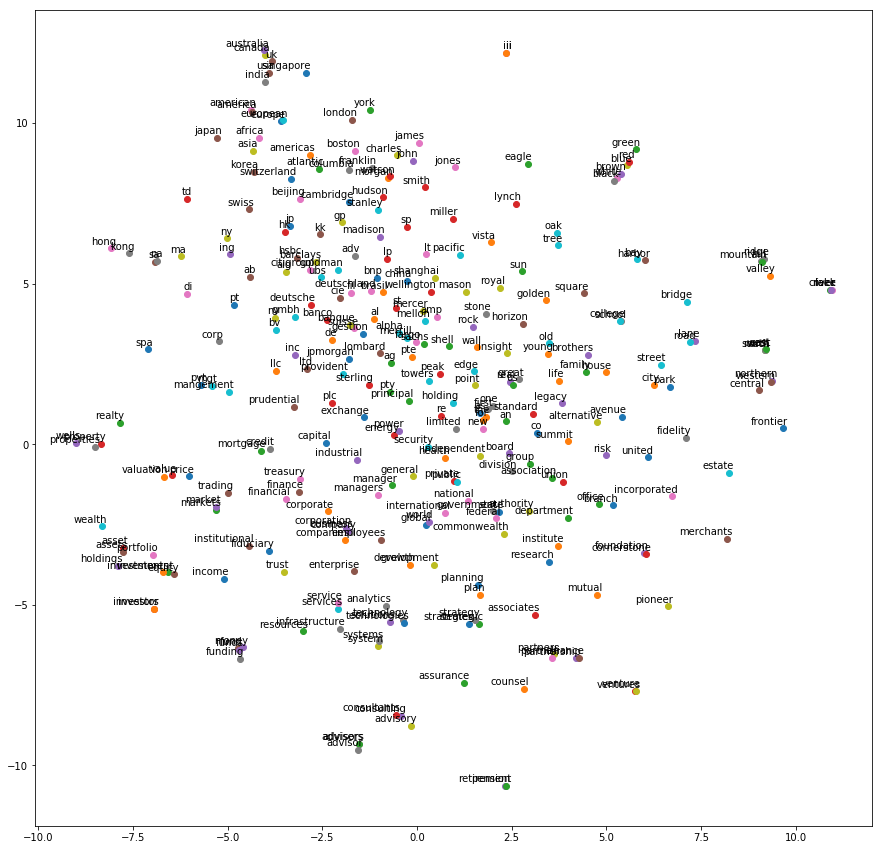

In [11]:
############################################################
# plot in 2D, after transforming 300-vectors with TSNE
############################################################

num_points = 300

tsne = TSNE(perplexity=30,
            n_components=2,
            init='pca',
            n_iter=5000)

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

two_d_embeddings = tsne.fit_transform(embeddings[1:num_points+1, :])
plot(two_d_embeddings, arraylabels[1:num_points+1])


In [12]:
############################################################
# dump files for embeddings projector
############################################################

file1 = 'fundnames_test1.tsv'
file2 = 'fundnames_test2.tsv'

tsv_rows, tsv_cols = embeddings.shape

print("creating file %s" % file1)
with open(file1, 'w') as outfile:
    for i in range(tsv_rows):
        e = embeddings[i]
        outfile.write("\t".join(["%f" % val for val in e]))
        outfile.write("\n")

print("creating file %s" % file2)
with open(file2, 'w') as outfile:
    #outfile.write("word\n")
    for i in range(tsv_rows):
        w = arraylabels[i]
        outfile.write(w)
        outfile.write("\n")


creating file fundnames_test1.tsv
creating file fundnames_test2.tsv


In [13]:
embed_df = pd.DataFrame(embeddings)
embed_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,...,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000,6128.000000
mean,-0.008231,0.032695,-0.000254,0.090793,-0.019542,-0.016407,0.007047,-0.089351,0.031849,0.064859,...,-0.015617,0.035691,-0.066787,0.024527,-0.016571,-0.050762,-0.035274,-0.042278,0.005686,0.062089
std,0.163270,0.150797,0.154628,0.158756,0.150417,0.164508,0.159532,0.158308,0.161638,0.152740,...,0.163970,0.163695,0.157116,0.155284,0.156539,0.162224,0.168833,0.151196,0.170295,0.163552
min,-0.757812,-0.542969,-0.656250,-0.480469,-1.070312,-0.792969,-0.609375,-0.843750,-0.714844,-0.550781,...,-0.652344,-0.718750,-0.917969,-0.800781,-0.679688,-0.812500,-0.789062,-0.617188,-0.691406,-0.761719
25%,-0.107422,-0.058594,-0.087402,-0.004898,-0.106445,-0.114258,-0.089844,-0.179688,-0.071289,-0.028107,...,-0.113281,-0.058594,-0.158203,-0.067871,-0.115234,-0.150635,-0.140625,-0.135742,-0.102051,-0.038391
50%,-0.015411,0.023560,0.006149,0.089844,-0.018860,-0.007812,0.004608,-0.078125,0.018860,0.060425,...,-0.004654,0.041016,-0.056152,0.029541,-0.019287,-0.052246,-0.041504,-0.043823,-0.007996,0.067383
75%,0.088989,0.122192,0.092773,0.186523,0.067871,0.085083,0.102539,0.008682,0.128906,0.155273,...,0.087402,0.132812,0.030518,0.117676,0.076172,0.046631,0.065430,0.044922,0.101685,0.166992
max,0.625000,0.738281,0.644531,0.812500,0.937500,0.609375,0.781250,0.636719,0.746094,0.695312,...,0.625000,0.695312,0.550781,0.808594,0.718750,0.605469,0.582031,0.843750,0.835938,0.710938


In [14]:
embed_df_transpose = embed_df.transpose()
embed_df_transpose.describe()

,0,1,2,3,4,5,6,7,8,9,...,6118,6119,6120,6121,6122,6123,6124,6125,6126,6127
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,-0.012733,-0.000835,-0.017047,-0.010675,-0.011240,-0.011040,-0.014419,-0.002959,-0.002563,0.003483,...,-0.021736,-0.003618,0.000476,0.002580,0.001543,-0.005542,0.000281,-0.021321,-0.008695,0.005377
std,0.134311,0.153145,0.201846,0.152705,0.160496,0.211764,0.185831,0.174025,0.141744,0.142093,...,0.204669,0.136979,0.105844,0.128725,0.058713,0.183806,0.227761,0.179023,0.126955,0.243323
min,-0.376953,-0.433594,-0.605469,-0.500000,-0.439453,-0.675781,-0.453125,-0.421875,-0.453125,-0.361328,...,-0.593750,-0.423828,-0.302734,-0.392578,-0.186523,-0.478516,-0.582031,-0.443359,-0.361328,-0.558594
25%,-0.105103,-0.098267,-0.142578,-0.122314,-0.113281,-0.144775,-0.127441,-0.115845,-0.095093,-0.106323,...,-0.151855,-0.095947,-0.071045,-0.085693,-0.036865,-0.137695,-0.152588,-0.141602,-0.095947,-0.155762
50%,-0.019348,0.000377,-0.038818,-0.005127,-0.005981,-0.007050,-0.019592,-0.019470,-0.000184,0.008224,...,-0.020447,0.007004,-0.000992,0.005402,0.005615,-0.014404,-0.025391,-0.011444,-0.009460,0.003124
75%,0.065186,0.106567,0.101807,0.092407,0.104004,0.129395,0.103271,0.114868,0.087769,0.100586,...,0.122314,0.083618,0.072388,0.093872,0.039429,0.113037,0.154053,0.102295,0.077148,0.166260
max,0.359375,0.437500,0.519531,0.417969,0.462891,0.460938,0.519531,0.464844,0.343750,0.384766,...,0.498047,0.341797,0.324219,0.404297,0.144531,0.574219,0.687500,0.500000,0.539062,0.843750


In [15]:
# k-means clustering

start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
num_clusters = 15

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( embeddings )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start

print "Time to perform k-means clustering: ", elapsed, "seconds."

Time to perform k-means clustering:  3.10504794121 seconds.


In [16]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( arraylabels, idx ))

def sort_list(mylist, mydict, ascending=True):
    retlist = [(mydict[key], key) for key in mylist]
    retlist.sort()
    if ascending == True:
        pass
    else:
        retlist = list(reversed(retlist))
    return([b for a,b in retlist])

popularity_dict = {}
for w in arraylabels:
    popularity_dict[w] = c[w]

popularity_list = [c[key] for key in arraylabels]

print(popularity_dict['development'])

min_per_cluster = 10
top_word_cutoff = 120

biglist = []
for cluster in xrange(num_clusters):
    #
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in xrange(0,len(word_centroid_map.values())):
        if( word_centroid_map.values()[i] == cluster ):
            words.append(word_centroid_map.keys()[i])
    # Print the cluster number  
    print "\nCluster %d (%d words)" % (cluster+1, len(words))
    # most popular in each cluster        
    templist = sort_list(words, popularity_dict, ascending=False)
    outlist = templist[:min_per_cluster]    
    j = min_per_cluster
    while j < len(templist) and popularity_dict[templist[j]] > top_word_cutoff:
        #print(j)
        outlist.append(templist[j])
        j += 1
    biglist.extend(outlist)
    print outlist

53

Cluster 1 (1 words)
['osmosis']

Cluster 2 (375 words)
['sa', 'hong', 'kong', 'de', 'al', 'deutsche', 'nv', 'ma', 'ab', 'fil']

Cluster 3 (728 words)
['limited', 'holding', 'the', 'first', 'retirement', 'real', 'point', 'us', 'blue', 'one']

Cluster 4 (737 words)
['inc', 'lp', 'corp', 'pacific', 'hk', 'pvt', 'ubs', 'hsbc', 'bnp', 'mgt']

Cluster 5 (147 words)
['eagle', 'tiger', 'lion', 'falcon', 'wolf', 'arrow', 'peregrine', 'owl', 'fur', 'fox']

Cluster 6 (153 words)
['gp', 'td', 'pt', 'lt', 'adv', 'kg', 'cv', 'ct', 'bp', 'gf']

Cluster 7 (247 words)
['alpha', 'amp', 'matrix', 'quantum', 'meridian', 'sigma', 'dimensional', 'crystal', 'constellation', 'symmetry']

Cluster 8 (353 words)
['asia', 'uk', 'singapore', 'canada', 'japan', 'india', 'morgan', 'europe', 'australia', 'american']

Cluster 9 (518 words)
['life', 'fidelity', 'brothers', 'golden', 'royal', 'millennium', 'man', 'beacon', 'baker', 'fortune']

Cluster 10 (713 words)
['management', 'advisors', 'partners', 'co', 'grou

In [18]:
# scatter chart
# x axes are PCA dimensions
# color is cluster number
# size is popularity

# PCA decomposition to show in 2 dimensions because TSNE didn't work great

pca = decomposition.PCA(n_components=2)
pca.fit(embeddings)
embeddings_2d = pca.transform(embeddings)

embeddings_2d.shape

(6128, 2)

In [19]:
# embeddings only for most popular, by cluster
filtered_embeddings = np.zeros((len(biglist), 2))
print(filtered_embeddings.shape)
for i, w in enumerate(biglist):
    print(i, w, arraydict[w])
    filtered_embeddings[i] = embeddings_2d[arraydict[w]]
    

(152, 2)
(0, 'osmosis', 5579)
(1, 'sa', 26)
(2, 'hong', 37)
(3, 'kong', 38)
(4, 'de', 52)
(5, 'al', 102)
(6, 'deutsche', 144)
(7, 'nv', 159)
(8, 'ma', 199)
(9, 'ab', 216)
(10, 'fil', 227)
(11, 'limited', 8)
(12, 'holding', 30)
(13, 'the', 32)
(14, 'first', 48)
(15, 'retirement', 63)
(16, 'real', 65)
(17, 'point', 69)
(18, 'us', 73)
(19, 'blue', 79)
(20, 'one', 108)
(21, 'inc', 5)
(22, 'lp', 14)
(23, 'corp', 28)
(24, 'pacific', 60)
(25, 'hk', 64)
(26, 'pvt', 71)
(27, 'ubs', 90)
(28, 'hsbc', 116)
(29, 'bnp', 111)
(30, 'mgt', 140)
(31, 'eagle', 133)
(32, 'tiger', 427)
(33, 'lion', 468)
(34, 'falcon', 549)
(35, 'wolf', 629)
(36, 'arrow', 599)
(37, 'peregrine', 950)
(38, 'owl', 963)
(39, 'fur', 917)
(40, 'fox', 806)
(41, 'gp', 129)
(42, 'td', 164)
(43, 'pt', 191)
(44, 'lt', 197)
(45, 'adv', 208)
(46, 'kg', 321)
(47, 'cv', 366)
(48, 'ct', 367)
(49, 'bp', 362)
(50, 'gf', 510)
(51, 'alpha', 120)
(52, 'amp', 267)
(53, 'matrix', 364)
(54, 'quantum', 410)
(55, 'meridian', 426)
(56, 'sigma', 522)


In [20]:
#plot 2d
popscale = list([math.log(pop)*2 for pop in popularity_list])

trace = go.Scatter(
    x = filtered_embeddings[:,0],
    y = filtered_embeddings[:,1],
    mode = 'markers',
    marker = dict(size=popscale,
                  color = list(word_centroid_map.values()),
                  colorscale='Rainbow',
                  showscale=False),
    text = arraylabels
)
     
data = [trace]

layout = go.Layout(hovermode='closest',
                   title='Popular words')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter')


In [21]:
# plot 3d
pca = decomposition.PCA(n_components=3)
pca.fit(embeddings)
embeddings_3d = pca.transform(embeddings)

filtered_embeddings_3d = np.zeros((len(biglist), 3))
print(filtered_embeddings_3d.shape)

for i in range(len(biglist)):
    filtered_embeddings_3d[i] = embeddings_3d[arraydict[biglist[i]]]

trace = go.Scatter3d(
    x = filtered_embeddings_3d[:,0],
    y = filtered_embeddings_3d[:,1],
    z = filtered_embeddings_3d[:,2],
    mode = 'markers',
    marker = dict(size=popscale,
                  color = list(word_centroid_map.values()),
                  colorscale='Rainbow',
                  showscale=False),
    text = arraylabels
)
     
data = [trace]

layout = go.Layout(hovermode='closest',
                   title='Popular words')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter3d')

# takeaway: k-means got interesting clusters, PCA doesn't cluster very well

(152, 3)


In [22]:
Z = linkage(embeddings, method='ward')

c, coph_dists = cophenet(Z, pdist(embeddings))
c

0.09274780563104817

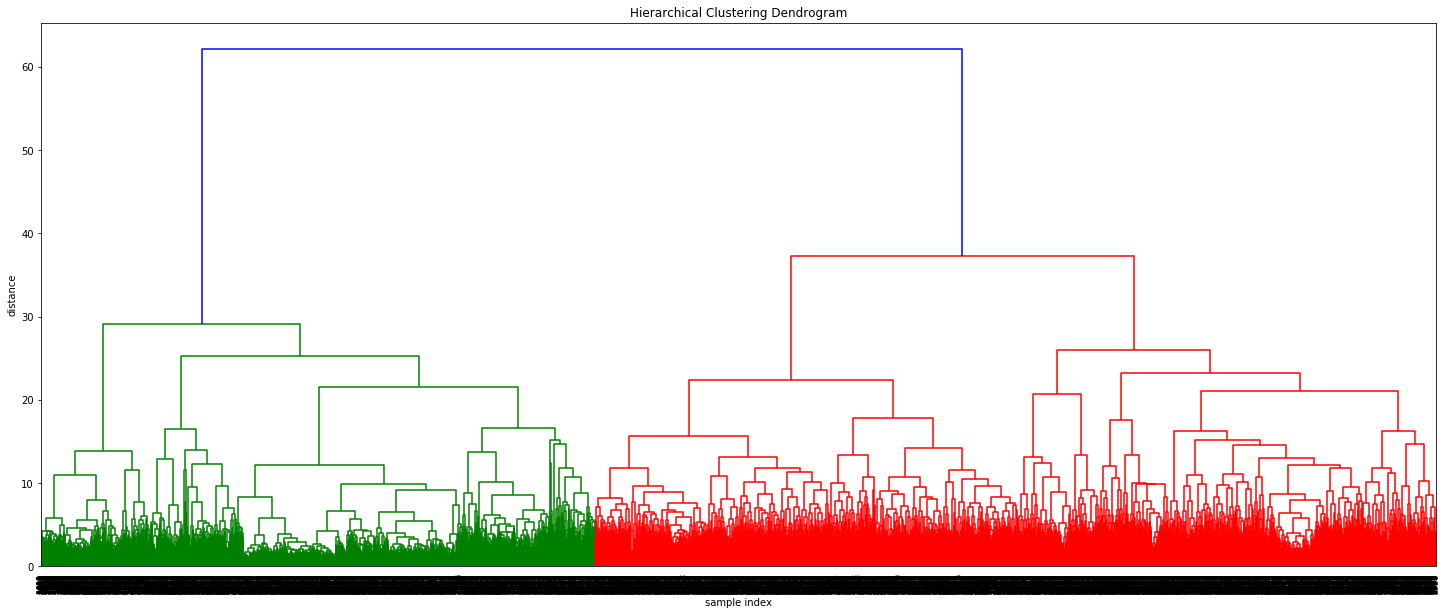

In [23]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [24]:
# the dendrogram clusters words semantically using the embeddings
# by walking the leaf nodes from left to right, we get a semantic ordering

def treewalk(node):
    retlist = []
    walked = False
    if node.left is not None:
        retlist.extend(treewalk(node.left))
        walked = True
    if node.right is not None:
        retlist.extend(treewalk(node.right))
        walked = True
    if walked:
        pass
    else:
        retlist.append(arraylabels[node.id])
    return retlist
                       
Ztree=hierarchy.to_tree(Z)

semantic_ordered_list = treewalk(Ztree)
semantic_ordered_dict = {w: i for i, w in enumerate(semantic_ordered_list)}
semantic_ordered_list


['harper',
 'blair',
 'robinson',
 'gordon',
 'cameron',
 'wright',
 'howard',
 'barry',
 'kennedy',
 'carter',
 'kerry',
 'mccain',
 'murray',
 'carl',
 'edwards',
 'reid',
 'davis',
 'johnson',
 'henry',
 'roy',
 'anderson',
 'williams',
 'lewis',
 'smith',
 'taylor',
 'evans',
 'phillips',
 'duncan',
 'gibson',
 'hughes',
 'ferguson',
 'bentley',
 'campbell',
 'cole',
 'bc',
 'adam',
 'jackson',
 'simpson',
 'hamilton',
 'nj',
 'louis',
 'troy',
 'wayne',
 'franklin',
 'lincoln',
 'jones',
 'collins',
 'hudson',
 'douglas',
 'murphy',
 'moore',
 'watson',
 'thompson',
 'adams',
 'matthew',
 'mitchell',
 'brandon',
 'stewart',
 'dennis',
 'morgan',
 'ross',
 'todd',
 'harris',
 'clark',
 'graham',
 'wilson',
 'kelly',
 'barnes',
 'simon',
 'warner',
 'daniel',
 'fred',
 'martin',
 'tim',
 'tom',
 'john',
 'edward',
 'scott',
 'james',
 'brian',
 'andrew',
 'craig',
 'william',
 'richard',
 'charles',
 'robert',
 'joseph',
 'kevin',
 'eric',
 'stephen',
 'russell',
 'anthony',
 'bruce

In [25]:
word_centroid_map.items()

[('poplar', 10),
 ('yellow', 10),
 ('cobia', 4),
 ('four', 2),
 ('woods', 12),
 ('aegis', 9),
 ('cyprus', 3),
 ('electricity', 13),
 ('lord', 8),
 ('meadows', 12),
 ('parallax', 6),
 ('dela', 1),
 ('skybridge', 12),
 ('oceans', 11),
 ('dell', 7),
 ('greentech', 13),
 ('nottingham', 14),
 ('haber', 1),
 ('succession', 2),
 ('sawgrass', 10),
 ('charter', 9),
 ('eagle', 4),
 ('miller', 3),
 ('precocity', 8),
 ('empirical', 9),
 ('second', 2),
 ('charted', 2),
 ('valiant', 8),
 ('melvin', 3),
 ('targa', 14),
 ('soave', 14),
 ('whaling', 11),
 ('thunder', 2),
 ('resilient', 2),
 ('admiral', 11),
 ('pioneering', 9),
 ('specialist', 9),
 ('affiliates', 13),
 ('highpass', 6),
 ('china', 10),
 ('affiliated', 9),
 ('climber', 4),
 ('golden', 8),
 ('stern', 2),
 ('unit', 9),
 ('derivatives', 13),
 ('dna', 3),
 ('dnb', 14),
 ('panoply', 8),
 ('symphony', 8),
 ('bedrock', 9),
 ('passport', 9),
 ('dnr', 14),
 ('strike', 2),
 ('successful', 9),
 ('belmont', 14),
 ('georgian', 14),
 ('holt', 3),
 ('gl

In [26]:
# commented out because we will use original k-means clustering above

# assign each word to a cluster, we will use clusters for coloring

#k=16
#mycluster = fcluster(Z, k, criterion='maxclust')

In [27]:
clusterdict = word_centroid_map # dict maps labels to clusters
clusters = []
clusters_sorted = []

# create num_clusters empty lists
for i in range(num_clusters):
    clusters.append([])

# append words of each cluster
for word, cluster_num in word_centroid_map.items():
    clusters[cluster_num].append(word)

min_per_cluster = 10
top_word_cutoff = 120

for i, cluster in enumerate(clusters):
    # Print the cluster number  
    print "\nCluster %d (%d words)" % (i, len(cluster))
    # most popular in each cluster        
    templist = sort_list(cluster, popularity_dict, ascending=False)
    # start with first 10
    outlist = templist[:min_per_cluster]
    # append additional items with populator at least 120
    j = min_per_cluster
    while j < len(templist) and popularity_dict[templist[j]] > top_word_cutoff:
        outlist.append(templist[j])
        j += 1
    outlist_sorted = sort_list(outlist, semantic_ordered_dict, ascending=False)
    clusters_sorted.append(outlist_sorted)
    print outlist_sorted



Cluster 0 (1 words)
['osmosis']

Cluster 1 (375 words)
['nv', 'deutsche', 'al', 'fil', 'de', 'ma', 'ab', 'sa', 'kong', 'hong']

Cluster 2 (728 words)
['blue', 'retirement', 'us', 'real', 'limited', 'the', 'one', 'point', 'first', 'holding']

Cluster 3 (737 words)
['mgt', 'corp', 'hk', 'hsbc', 'bnp', 'ubs', 'lp', 'pvt', 'inc', 'pacific']

Cluster 4 (147 words)
['eagle', 'arrow', 'fur', 'wolf', 'owl', 'falcon', 'peregrine', 'fox', 'tiger', 'lion']

Cluster 5 (153 words)
['bp', 'adv', 'pt', 'td', 'cv', 'lt', 'gp', 'kg', 'gf', 'ct']

Cluster 6 (247 words)
['amp', 'meridian', 'crystal', 'quantum', 'matrix', 'symmetry', 'dimensional', 'sigma', 'alpha', 'constellation']

Cluster 7 (353 words)
['singapore', 'canada', 'uk', 'australia', 'asia', 'japan', 'india', 'american', 'europe', 'morgan']

Cluster 8 (518 words)
['beacon', 'baker', 'fortune', 'royal', 'life', 'man', 'brothers', 'millennium', 'golden', 'fidelity']

Cluster 9 (713 words)
['trust', 'group', 'counsel', 'corporation', 'private'

In [28]:
orderlist = {}
for l in clusters_sorted:
    orders = [semantic_ordered_dict[w] for w in l]
    order_avg = sum(orders)*1.0/len(orders)
    orderlist[order_avg] = l
    print(l)
    print(order_avg)
    
clusters_ordered = [orderlist[k] for k in sorted(orderlist.keys())]

# renumber clusters
for i, cluster in enumerate(clusters_ordered):
    for w in cluster:
        clusterdict[w] = i

['osmosis']
3435.0
['nv', 'deutsche', 'al', 'fil', 'de', 'ma', 'ab', 'sa', 'kong', 'hong']
911.7
['blue', 'retirement', 'us', 'real', 'limited', 'the', 'one', 'point', 'first', 'holding']
3067.7
['mgt', 'corp', 'hk', 'hsbc', 'bnp', 'ubs', 'lp', 'pvt', 'inc', 'pacific']
2119.3
['eagle', 'arrow', 'fur', 'wolf', 'owl', 'falcon', 'peregrine', 'fox', 'tiger', 'lion']
4879.7
['bp', 'adv', 'pt', 'td', 'cv', 'lt', 'gp', 'kg', 'gf', 'ct']
2440.5
['amp', 'meridian', 'crystal', 'quantum', 'matrix', 'symmetry', 'dimensional', 'sigma', 'alpha', 'constellation']
5065.8
['singapore', 'canada', 'uk', 'australia', 'asia', 'japan', 'india', 'american', 'europe', 'morgan']
965.9
['beacon', 'baker', 'fortune', 'royal', 'life', 'man', 'brothers', 'millennium', 'golden', 'fidelity']
4299.0
['trust', 'group', 'counsel', 'corporation', 'private', 'consulting', 'advisors', 'advisory', 'associates', 'partners', 'research', 'management', 'services', 'international', 'co']
3984.0
['china', 'emerald', 'brown', 'ha

In [29]:
biglist = []
for l in clusters_ordered:
    biglist.extend(l)
biglist

['nv',
 'deutsche',
 'al',
 'fil',
 'de',
 'ma',
 'ab',
 'sa',
 'kong',
 'hong',
 'singapore',
 'canada',
 'uk',
 'australia',
 'asia',
 'japan',
 'india',
 'american',
 'europe',
 'morgan',
 'ii',
 'shanghai',
 'bv',
 'gmbh',
 'ltd',
 'llc',
 'suisse',
 'pte',
 'pty',
 'banco',
 'mgt',
 'corp',
 'hk',
 'hsbc',
 'bnp',
 'ubs',
 'lp',
 'pvt',
 'inc',
 'pacific',
 'bp',
 'adv',
 'pt',
 'td',
 'cv',
 'lt',
 'gp',
 'kg',
 'gf',
 'ct',
 'blue',
 'retirement',
 'us',
 'real',
 'limited',
 'the',
 'one',
 'point',
 'first',
 'holding',
 'osmosis',
 'ag',
 'managers',
 'company',
 'markets',
 'trading',
 'investors',
 'asset',
 'holdings',
 'investments',
 'investment',
 'financial',
 'capital',
 'funds',
 'fund',
 'wealth',
 'global',
 'trust',
 'group',
 'counsel',
 'corporation',
 'private',
 'consulting',
 'advisors',
 'advisory',
 'associates',
 'partners',
 'research',
 'management',
 'services',
 'international',
 'co',
 'beacon',
 'baker',
 'fortune',
 'royal',
 'life',
 'man',
 'broth

In [30]:
chartlist = []
for w in biglist:
    chartlist.append((w, clusterdict[w], popularity_dict[w]))
    
chartlist

[('nv', 0, 28),
 ('deutsche', 0, 32),
 ('al', 0, 46),
 ('fil', 0, 19),
 ('de', 0, 108),
 ('ma', 0, 22),
 ('ab', 0, 20),
 ('sa', 0, 272),
 ('kong', 0, 175),
 ('hong', 0, 177),
 ('singapore', 1, 115),
 ('canada', 1, 99),
 ('uk', 1, 130),
 ('australia', 1, 56),
 ('asia', 1, 157),
 ('japan', 1, 63),
 ('india', 1, 61),
 ('american', 1, 55),
 ('europe', 1, 59),
 ('morgan', 1, 59),
 ('ii', 2, 31),
 ('shanghai', 2, 118),
 ('bv', 2, 48),
 ('gmbh', 2, 149),
 ('ltd', 2, 2215),
 ('llc', 2, 3607),
 ('suisse', 2, 44),
 ('pte', 2, 324),
 ('pty', 2, 322),
 ('banco', 2, 39),
 ('mgt', 3, 33),
 ('corp', 3, 270),
 ('hk', 3, 88),
 ('hsbc', 3, 42),
 ('bnp', 3, 41),
 ('ubs', 3, 54),
 ('lp', 3, 801),
 ('pvt', 3, 77),
 ('inc', 3, 2244),
 ('pacific', 3, 95),
 ('bp', 4, 12),
 ('adv', 4, 21),
 ('pt', 4, 23),
 ('td', 4, 26),
 ('cv', 4, 12),
 ('lt', 4, 22),
 ('gp', 4, 37),
 ('kg', 4, 14),
 ('gf', 4, 9),
 ('ct', 4, 12),
 ('blue', 5, 61),
 ('retirement', 5, 88),
 ('us', 5, 69),
 ('real', 5, 86),
 ('limited', 5, 1314)

In [31]:
# co-occurence matrix
matrix_dim = len(biglist)
comatrix = np.zeros((matrix_dim, matrix_dim), np.int)

matrixlist = [mytuple[0] for mytuple in chartlist]

for name in uniquelines.keys():
    words = name.split()
    for w in words:
        if w not in matrixlist:
            continue
        w_index = matrixlist.index(w)
        for v in words:
            if v not in matrixlist:
                continue
            v_index = matrixlist.index(v)
            if v_index <> w_index:
                comatrix[w_index][v_index] += 1
            
#counts_array = np.array(list([count[dictionary[name]][1] for name in biglist]))
#comatrix = comatrix / counts_array
np.set_printoptions(suppress=True)
comatrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1,
       0, 3, 1, 0, 4, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       4, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
from colour import Color
colors = list(Color("purple").range_to(Color("red"),15))
#colorstrings = [col.get_hex() for col in colors]
colortuples = [col.get_rgb() for col in colors]
colortuples2 = [(int(r*255), int(g*255), int(b*255), 0.25) for r,g,b in colortuples]
cols = ['rgba(%d, %d, %d, %f)' % colortuples2[groupno-1] for label, groupno, count in chartlist]
colortuples3 = [(int(r*255), int(g*255), int(b*255), 0.95) for r,g,b in colortuples]
label_colors = ['rgba(%d, %d, %d, %f)' % colortuples3[groupno-1] for label, groupno, count in chartlist]
colortuples2[0]

(128, 0, 127, 0.25)

In [33]:
npoints = len(chartlist)
angles = [i*1.0/npoints * 2 * np.pi for i in range(npoints)]
x = [math.sin(ang) for ang in angles]
y = [math.cos(ang) for ang in angles]
labels = ["%s" % (label) for label, group, count in chartlist]
rollover_texts = ["%s<br>%d firms" % (label, count) for label, group, count in chartlist]
groups = [group for label, group, count in chartlist]
counts = [1.5*math.log(count) +1 for label, group, count in chartlist]


In [34]:
# make list of shapes for chords
shapelist = []
for i in range(npoints):
    for j in range(npoints):
        if i >= j:
            continue
        if comatrix[i,j] < 3:
            continue
        shapelist.append(
            {
        'type': 'line',
        'x0': x[i],
        'y0': y[i],
        'x1': x[j],
        'y1': y[j],
        'line': {
            'color': cols[j],
            'width': 1,
        },
    }
)
npoints

152

In [35]:
xoffset = list(np.arange(-9, 3, 12.0/39))
xoffset.extend(list(np.arange(3, -8, -11.0/39)))
xoffset.extend(list(np.arange(8, -3, -11.0/39)))
xoffset.extend(list(np.arange(-3, 8, +11.0/38)))
print(len(xoffset))

yoffset = list(np.arange(2, -8, -10.0/39))
yoffset.extend(list(np.arange(8, -2, -10.0/39)))
yoffset.extend(list(np.arange(-2, 8, 10.0/39)))
yoffset.extend(list(np.arange(-8, 2, 10.0/38)))
#yoffset.extend(list(np.arange( 8, -2-10.0/39, -10.0/39)))
#yoffset.extend(list(np.arange( -2, 8+10.0/39, 10.0/39)))
#yoffset.extend(list(np.arange( -8, 2+10.0/39, 10.0/39)))
print(len(yoffset))

155
155


In [36]:
### make list of annotations for labels

angle_degrees1 = [(i*1.0/npoints * 360 + 270) for i in range(npoints)]
angle_degrees = [(ang_deg + 180) % 360 if ang_deg > 450 else ang_deg % 360 for ang_deg in angle_degrees1 ]
xanchor = list(["right" if (ang_deg > 450) else "left" for ang_deg in angle_degrees1])
yanchor = list(["top" if ((ang_deg >= 360) and (ang_deg < 540)) else "bottom" for ang_deg in angle_degrees1])

#< 90 or >= 270
#% 360

annotations = []
for i in range(len(chartlist)):
    annotations.append(
        dict(
            x=x[i],
            y=y[i],
            xref='x',
            yref='y',
            xshift = xoffset[i],          
            yshift = yoffset[i],
            text=labels[i],
            textangle=angle_degrees[i],
            xanchor=xanchor[i],
            yanchor=yanchor[i],
            showarrow=False,
            font=dict(
                size=9,
                color=label_colors[i]                
            )
        ))


In [37]:

trace1 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    name='Marker',
    text=rollover_texts,
#    textfont={"color": groups,
#              "colorscale": 'Rainbow',
#              "family": "Arial, sans-serif",
#              "size": 10,        
#            },
    marker = dict(
        size = counts,
        color = groups,
        colorscale = 'Rainbow',
#        color = cols,
        ),
#    textposition='bottom'
    hoverinfo="text",
)

data = [trace1]
layout = go.Layout(title="Selected Words From Firm Names<br>With Collocation Relationships",
                   titlefont = dict(size=24, family='Times New Roman, serif'),
                   autosize=False,
                   width=650,
                   height=650,
                   paper_bgcolor='#fff',
                   plot_bgcolor='#fff',                                      
                   hovermode='closest',
                   showlegend=False,
                   xaxis=dict(
                       autorange=True,
                       showgrid=False,
                       zeroline=False,
                       showline=False,
                       autotick=True,
                       ticks='',
                       showticklabels=False
                   ),
                   yaxis=dict(
                       autorange=True,
                       showgrid=False,
                       zeroline=False,
                       showline=False,
                       autotick=True,
                       ticks='',
                       showticklabels=False
                   ),    
                   shapes = shapelist,
                   annotations=annotations,                   
                  )


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='circle')

